In [1]:
from __future__ import division

import os
import pandas as pd                     
import numpy as np
import math
from matplotlib import pyplot as plt
from matplotlib import rc, rcParams
import scipy.integrate as integrate
from scipy import interpolate
from scipy.interpolate import griddata
import pylab
from astropy.io import fits
import time
import scipy.special as bessel
import sys
import scipy.optimize as opt
from scipy.optimize import curve_fit
import matplotlib.ticker as mticker

In [2]:
###############
# LaTeX block #
###############

rc('text', usetex=True)
rc('font',**{'family':'serif','serif':['Palatino']})
rc('xtick', labelsize=18)
rc('ytick', labelsize=18)
rcParams['legend.numpoints'] = 1

In [3]:
########################################################
# CONSTANTS: physical constants and conversion factors #
########################################################

pi = math.pi                    # pi-greek
pc_mt = 3.0857e+16              # parsec in meters
pc_cm = 3.0857e+18              # parsec in centimeters
m_to_pc = pow(pc_mt,-1)         # to pass from meters to parsec
cm_to_pc = 3.24 * pow(10,-19)   # to pass from centimeters to parsec
m_p = .939                      # proton mass in GeV/c^2
m_e = 0.000510998918            # electron mass in GeV/c^2
conv_factor_GeV_to_erg = 0.00160218   # the value in [GeV] has to be multipled by this factor
conv_factor_erg_to_GeV = 624.151
conv_factor_yr_to_sec = 31.56*pow(10,6)
c = 2.99*pow(10,10)             # speed of light in [cm sec^(-1)]
b_0 = 1.4*pow(10,-16)           # energy loss coefficient (due to IC scattering and synchrotron) in [GeV^(-1) s^(-1)]

In [4]:
######################
### ISM parameters ###
######################

gamma_ratio = m_p/m_e

# HALO (assumed 6 kpc)
# here it is only useful to show the truncation scale
L_halo = 100                  # injection scale of the turbulence, in [parsec]
M_A_halo = 1.                 # Alfvénic Mach Number
beta_halo = 0.14              # P_gas/P_mag
v_A_halo = pow(10,6)          # 10[km/s] in [cm/s]
Halo_size_minus_WIM = 5100.   # in [parsec]


# Disk (it is actually the WIM region)
L_disk = 100               # injection scale of the turbulence, in [parsec]
M_A_disk = 1.              # Alfvénic Mach Number
beta_disk = 0.14
x_c = pow(10,6)            # for standard ISM conditions
WIM_size = 900.            # in [parsec]

# <center>Truncation Scale
    
### Collisionless damping

$$\begin{align}
&k_{max} L = \frac{4 \, M_A^4 \, \gamma \, \xi^2}{\pi \, \beta \, (1 - \xi^2)^2} e^{\frac{2}{\beta \, \gamma \, \xi^2}}\\[10pt]
&\gamma = \frac{m_p}{m_e}\\[10pt]
&\beta = \frac{P_g}{P_B}
\end{align}$$

### Collisional damping (viscous)

$$\begin{align}
&k_{max} L = \begin{cases}
    x_c \, (1 - \xi^2)^{-2/3} & \beta \ll 1\\
    x_c \, (1 - 3 \, \xi^2)^{-4/3} & \beta \gg 1
  \end{cases}\\[10pt]
&x_c =  \left( \frac{6 \, \rho \, \delta V^2 \, L}{\eta_0 \, v_A} \right)^{2/3} \; \sim \; 10^6
\end{align}$$

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


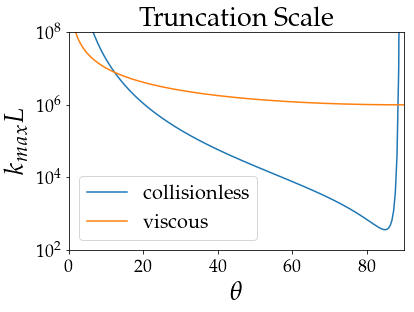

In [5]:
##################################################
### Calculate the truncation scale for damping ###
##################################################

theta = np.linspace(0., 90., num=200)   # wave pitch-angle in degrees
                                        # for M_A > 0.8 -> num=200 is sufficient
                                        # for M_A = 0.5 -> num=500 is sufficient
                                        # for M_A = 0.3 -> num=700 is sufficient
                                        # for M_A = 0.1 -> num=800 is sufficient

# collisionless
def kmax_L_func_coll(theta_arr):
    kmax_L_arr_collisionless = np.zeros(len(theta_arr))
    for i in range(len(theta_arr)):
        kmax_L_arr_collisionless[i] = ( 4 * pow(M_A_disk,4) * gamma_ratio * pow(np.cos(np.radians(theta[i])),2) ) / ( pi * beta_disk * ( pow(np.sin(np.radians(theta[i])),4) ) ) * np.exp(2 / ( beta_disk * gamma_ratio * pow(np.cos(np.radians(theta[i])),2) ) )
    return kmax_L_arr_collisionless

# collisional (viscous)
def kmax_L_func_visc(theta_arr):
    kmax_L_arr_viscous = np.zeros(len(theta_arr))
    for i in range(len(theta_arr)):
        kmax_L_arr_viscous[i] = x_c * pow( 1 - pow(np.cos(np.radians(theta[i])),2) , -2/3)
    return kmax_L_arr_viscous
        
kmax_L_H, = plt.plot(theta, kmax_L_func_coll(theta))
kmax_L_d, = plt.plot(theta, kmax_L_func_visc(theta))

plt.legend([kmax_L_H, kmax_L_d],[
    r'collisionless',
    r'viscous',
    ],loc='best', fontsize=20)

plt.title("Truncation Scale", fontsize=27, loc='center', pad=None)

plt.axis([0.,90., 1.e2,1.e8],interpolation='none')
plt.xlabel('$\\theta$',fontsize=27)
plt.ylabel('$k_{max}L$',fontsize=27)
plt.yscale('log')

plt.savefig('Truncation_scales.pdf',format='pdf',bbox_inches='tight', dpi=200)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars


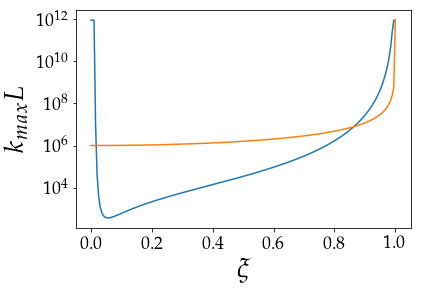

In [6]:
# Dissipation-scale of the turbulence

r_L_minE = 3.37 * pow(10,10)             # in [cm], for 10^{-2} GeV particles
r_L_inverse_minE_2ordersMore = ( 1 / (r_L_minE) ) * pow(10,2)     # max k

kmax_L_coll_array = np.zeros( len(theta)  )
kmax_L_coll_minscale = np.zeros( len(theta)  )
kmax_L_visc_array = np.zeros( len(theta)  )
kmax_L_visc_minscale = np.zeros( len(theta)  )

kmax_L_reversed_coll = np.zeros( len(theta)  )
kmax_L_reversed_visc = np.zeros( len(theta)  )


kmax_L_coll_array = kmax_L_func_coll(theta)
for j in range(len(theta)):
    kmax_L_coll_minscale[j] = min(kmax_L_coll_array[j], r_L_inverse_minE_2ordersMore * (L_disk*pc_cm))
kmax_L_reversed_coll = kmax_L_coll_minscale[::-1]

kmax_L_visc_array = kmax_L_func_visc(theta)
for i in range(len(theta)):
    kmax_L_visc_minscale[i] = min(kmax_L_visc_array[i], r_L_inverse_minE_2ordersMore * (L_disk*pc_cm))

kmax_L_reversed_visc = kmax_L_visc_minscale[::-1]

csi = np.linspace(0., 1., num=len(theta))

plt.plot(csi, kmax_L_reversed_coll)   # just to check it's correct
plt.plot(csi, kmax_L_reversed_visc)

plt.xlabel('$\\xi$',fontsize=27)
plt.ylabel('$k_{max}L$',fontsize=27)
plt.yscale('log')

# <center>Diffusion Coefficient

### $D_{\mu \mu}$ for fast-modes TTD

$$\begin{align}
&D^{T}_{\mu \mu} \, \frac{L}{v} = \frac{M_A^2 \sqrt{\pi} \, (1 - \mu^2)^{1/2}}{2 R^2 M^{1/2}_A} \, \int^1_0 d \xi \int^{k_{max}L(\xi)}_1 dx \, \xi \, J_1^2(\omega) \, x^{-5/2} e^{-\frac{ \left(\mu \, - \, \frac{v_A}{c \, \xi}\right)^2 }{(1 - \mu^2) M_A} } \\[10pt]
&\omega = R \, x \, (1 - \xi^2)^{1/2} (1 - \mu^2)^{1/2} \\[10pt]
&R = \frac{r_L}{L}
\end{align}$$

### $D_{\mu \mu}$ for fast-modes Gyroresonance

$$D^{G}_{\mu \mu} \, \frac{L}{v} = \frac{M_A^2 \sqrt{\pi} \, (1 - \mu^2)^{1/2}}{2 R^2 M^{1/2}_A} \, \int^1_0 d \xi \int^{k_{max}L(\xi)}_1 dx \, \xi \, \sum^{+\infty}_{n=-\infty} J_n^{'2}(\omega) \, x^{-5/2} e^{-\frac{ \left(\mu \, - \, \frac{n}{x \, R \, \xi}\right)^2 }{(1 - \mu^2) M_A} }$$

$$(D^{G, n=+1}_{\mu \mu} + D^{G, n=-1}_{\mu \mu}) \cdot \frac{L}{v} = \frac{M_A^{3/2} \sqrt{\pi} \, (1 - \mu^2)^{1/2}}{2 R^2} \, \int^1_0 d \xi \int^{k_{max}L(\xi)}_1 dx \, \xi \, \left( \frac{J_0(\omega) - J_2(\omega)}{2} \right)^2 \, x^{-5/2} \left( e^{-\frac{ \left(\mu \, + \, \frac{n}{x \, R \, \xi}\right)^2 }{(1 - \mu^2) M_A} } + e^{-\frac{ \left(\mu \, - \, \frac{n}{x \, R \, \xi}\right)^2 }{(1 - \mu^2) M_A} } \right) $$

### $D_{\mu \mu}$ for Alfvén modes
### $(M_A \leq 1)$

$$ D^A_{\mu \mu} = \frac{2 v M^{4/3}_A \sqrt{\pi} \, (1 - \mu^2)^{1/2}}{3 L R^2 M_A^{1/2}} \, \int d x_{\parallel} \int d x_{\perp} \sum_{n=-\infty}^{+\infty} \frac{n^2 \, J^2_{n}(\omega)}{\omega^2} \cdot \frac{x_{\perp}^{-7/3}}{x_{\parallel}} \cdot e^{-\left( \frac{x_{\parallel}}{M_A^{4/3} x_{\perp}^{2/3}} + \frac{ \left( \mu \, + \, \frac{n}{x_{\parallel} R} \right)^2}{M_A \, (1 - \mu^2)}  \right)}$$

$$\begin{align}
&\left( D^{A, \, n=+1}_{\mu \mu} + D^{A, \, n=-1}_{\mu \mu} \right) \cdot \frac{L}{v} = \frac{2 M_A^{5/6} \sqrt{\pi} \, (1 - \mu^2)^{1/2}}{3 R^2} \, \int d x_{\parallel} \int d x_{\perp} \frac{J^2_{1}(\omega)}{\omega^2} \cdot \frac{x_{\perp}^{-7/3}}{x_{\parallel}} \cdot e^{- \frac{x_{\parallel}}{M_A^{4/3} x_{\perp}^{2/3}} } \left( e^{-\frac{ \left(\mu \, + \, \frac{n}{x_{\parallel} \, R}\right)^2 }{(1 - \mu^2) M_A} } + e^{-\frac{ \left(\mu \, - \, \frac{n}{x_{\parallel} \, R}\right)^2 }{(1 - \mu^2) M_A} } \right)  \\[10pt]
&x_{\perp, min} \equiv k_{\perp, min} \ell_{\mathrm{tr}} = 1 \, \Rightarrow \, x_{\perp, min} = k_{\perp, min} \cdot \left( \frac{\ell_{\mathrm{tr}}}{L} \right) L = 1 \, \Rightarrow \, {\color{red}x_{\perp, min}} = \frac{1}{\left( \frac{\ell_{\mathrm{tr}}}{L} \right)} \approx M_A^{-2}, \\ 
&x_{\perp, max} \equiv k_{\perp, max} L \gg r^{-1}_L|_{_{E_{min}}} L  \quad \Rightarrow \quad {\color{blue}x_{\perp, max}} = 10^2 \cdot 3 \cdot 10^{-11} \mathrm{cm}^{-1} L \, @ \, E_{min} = 10^{-2} \, \mathrm{GeV}\\[10pt]
&\color{red}x_{\parallel, min} = 1, \qquad \qquad \color{blue}x_{\parallel, max} = x_{\perp, max}^{2/3}
\end{align}$$

### $(M_A > 1)$

$$
D^A_{\mu \mu} = \frac{2 v M_A \sqrt{\pi} \, (1 - \mu^2)^{1/2}}{3 L R^2 M_A^{1/2}} \, \int d x_{\parallel} \int d x_{\perp} \sum_{n=-\infty}^{+\infty} \frac{n^2 \, J^2_{n}(\omega)}{\omega^2} \cdot \frac{x_{\perp}^{-7/3}}{x_{\parallel}} \cdot e^{-\left( \frac{x_{\parallel}}{M_A x_{\perp}^{2/3}} + \frac{ \left( \mu \, + \, \frac{n}{x_{\parallel} R} \right)^2}{M_A \, (1 - \mu^2)}  \right)} $$

$$\left( D^{A, \, n=+1}_{\mu \mu} + D^{A, \, n=-1}_{\mu \mu} \right) \cdot \frac{L}{v} = \frac{2 M_A^{1/2} \sqrt{\pi} \, (1 - \mu^2)^{1/2}}{3 R^2} \, \int d x_{\parallel} \int d x_{\perp} \frac{J^2_{1}(\omega)}{\omega^2} \cdot \frac{x_{\perp}^{-7/3}}{x_{\parallel}} \cdot e^{- \frac{x_{\parallel}}{M_A x_{\perp}^{2/3}} } \left( e^{-\frac{ \left(\mu \, + \, \frac{n}{x_{\parallel} \, R}\right)^2 }{(1 - \mu^2) M_A} } + e^{-\frac{ \left(\mu \, - \, \frac{n}{x_{\parallel} \, R}\right)^2 }{(1 - \mu^2) M_A} } \right)$$

$$\begin{align}
&x_{\perp, min} \equiv k_{\perp, min} \ell_{\mathrm{tr}} = 1 \, \Rightarrow \, x_{\perp, min} = k_{\perp, min} \cdot \left( \frac{\ell_{\mathrm{tr}}}{L} \right) L = 1 \, \Rightarrow \, {\color{red}x_{\perp, min}} = \frac{1}{\left( \frac{\ell_{\mathrm{tr}}}{L} \right)} \approx M_A^{3}, \\ 
&x_{\perp, max} \equiv k_{\perp, max} L \gg r^{-1}_L|_{_{E_{min}}} L  \quad \Rightarrow \quad {\color{blue}x_{\perp, max}} = 10^2 \cdot 3 \cdot 10^{-11} \mathrm{cm}^{-1} L \, @ \, E_{min} = 10^{-2} \, \mathrm{GeV}\\[10pt]
&\color{red}x_{\parallel, min} \approx M_A^{3}, \qquad \qquad \color{blue}x_{\parallel, max} = x_{\perp, max}^{2/3}
\end{align}$$


### <center>Condition on each $\mu$ for diffusive regime
    
$$\left( \frac{2  D_{\mu \mu}}{1 - \mu^2} \right)^{-1} \cdot c \equiv \Delta x < \frac{L_{\mathrm{H,D}}}{5}$$


### <center>Final Integral
    
$$D(R) = \frac{1}{4} \int_{0}^{\mu^*} d\mu \, \frac{v^2 \, (1 - \mu^2)^2}{D^{f,T}_{\mu \mu}  + D^{f,G}_{\mu \mu} + D^{A,G}_{\mu \mu}}$$

In [7]:
########################################
### Calculate the D(R) in the Disk #####
########################################

### Calculate the D_mumu in the Disk ###

# Define the integration variables #
length_energy_array = 60
length_mu_array = 30
length_x_perp_alf_disk_array = 100       # 800/1000 should be fine should be fine to let the wiggles in the Alfvén modes disappear
length_x_parallel_alf_disk_array = 100   # 800/1000
length_x_array = 100


p_CR = np.logspace(-1, 5, num=length_energy_array)
r_L = np.zeros(len(p_CR))
R_disk = np.zeros(len(p_CR))

r_L = [3.37 * pow(10,12) * p_CR[i] for i in range(len(p_CR))]   # (p/1GeV)*(1/Z)*(10^{-6}G/B), in [cm] and c=1
R_disk = [r_L[i] / (L_disk*pc_cm) for i in range(len(p_CR))]

mu = np.linspace(0., 0.999, num=length_mu_array)

x_perp_max_disk = r_L_inverse_minE_2ordersMore * (L_disk*pc_cm)
x_parallel_max_disk = pow(x_perp_max_disk, 2/3)


if (M_A_disk <= 1):
    x_perp_min_disk = pow(M_A_disk, -2)
    x_parallel_min_disk = 1
    
elif (M_A_disk > 1):
    x_perp_min_disk = pow(M_A_disk, 3)
    x_parallel_min_disk = pow(M_A_disk, 3)

        

print ("Length of R array:", len(R_disk), "in the range:", min(R_disk),max(R_disk))
print ("Length of mu array:", len(mu), "in the range:", min(mu),max(mu))
print ("Length of theta array:", len(theta), "in the range:", min(theta),max(theta))
print ("Length of csi array (must be the same as theta):", len(csi), "in the range:", min(csi),max(csi))
print ("Length of kmax_L_viscous array (must be the same as theta):", len(kmax_L_reversed_visc), "in the range:", min(kmax_L_reversed_visc),max(kmax_L_reversed_visc))
print ("Length of kmax_L_collisionless array (must be the same as theta):", len(kmax_L_reversed_coll), "in the range:", min(kmax_L_reversed_coll),max(kmax_L_reversed_coll))


## Fast Modes ##
# TTD 
integral_over_x_TTD_disk = np.zeros( (len(R_disk),len(mu),len(csi)) )
integral_over_csi_TTD_disk = np.zeros( (len(R_disk),len(mu)) )
D_mumu_TTD_over_v_disk = np.zeros( (len(R_disk),len(mu)) )

# Gyroresonance 
integral_over_x_Gyro_disk = np.zeros( (len(R_disk),len(mu),len(csi)) )
integral_over_csi_Gyro_disk = np.zeros( (len(R_disk),len(mu)) )
D_mumu_Gyro_over_v_disk = np.zeros( (len(R_disk),len(mu)) )


## Alfvén modes ##
x_perp_alf_disk = np.logspace(np.log10(x_perp_min_disk), np.log10(x_perp_max_disk), length_x_perp_alf_disk_array) 
x_parallel_alf_disk = np.logspace(np.log10(x_parallel_min_disk), np.log10(x_parallel_max_disk), length_x_parallel_alf_disk_array)

bessel_arg_alf_disk = np.zeros( (len(R_disk),len(mu),len(x_perp_alf_disk)) )
bessel_func_square_alf_disk_ratio = np.zeros( (len(R_disk),len(mu),len(x_perp_alf_disk)) )

power_alf_disk = np.zeros( (len(x_parallel_alf_disk), len(x_perp_alf_disk)) )

exponential_arg_alf_disk_first = np.zeros( (len(x_parallel_alf_disk),len(x_perp_alf_disk)) )
exponential_arg_alf_disk_second = np.zeros( (len(R_disk),len(mu),len(x_parallel_alf_disk)) )
exponential_arg_alf_disk_second_2 = np.zeros( (len(R_disk),len(mu),len(x_parallel_alf_disk)) )
exponential_alf_disk = np.zeros( (len(R_disk),len(mu),len(x_parallel_alf_disk),len(x_perp_alf_disk)) )

integrand_xperp_alf_disk = np.zeros( (len(R_disk),len(mu),len(x_parallel_alf_disk),len(x_perp_alf_disk)) )
integral_over_xperp_alf_disk = np.zeros( (len(R_disk),len(mu),len(x_parallel_alf_disk)) )
integral_over_xparallel_alf_disk = np.zeros( (len(R_disk),len(mu)) )
D_mumu_Alfven_over_v_disk = np.zeros( (len(R_disk),len(mu)) )


## Total ##
integrand_mu_disk = np.zeros( (len(R_disk),len(mu)) )
D_mumu_TOT_disk = np.zeros( (len(R_disk),len(mu)) )
scattering_frequency_disk = np.zeros( (len(R_disk),len(mu)) )
integral_over_mu_disk = np.zeros( len(R_disk) )


# Beginning of the actual calculation. It may take from ~25 minutes up to a few hours
start_time = time.process_time()

for r in range(len(R_disk)):
    
    for m in range(len(mu)):
        
        # Fast modes
        for i in range(len(csi)):

            # building the array for the integration variable x. Here is the difference with the Halo case #
            x_array_disk = np.logspace(0, np.log10( min( kmax_L_reversed_visc[i],kmax_L_reversed_coll[i] ) ), num=length_x_array)
            
            bessel_arg_disk = np.zeros( (len(R_disk),len(mu),len(csi),len(x_array_disk)) )
            power_disk = np.zeros(len(x_array_disk))

            # TTD 
            exponential_TTD = np.zeros( (len(mu),len(csi)) )
            bessel_func_square_TTD_disk = np.zeros( (len(R_disk),len(mu),len(csi),len(x_array_disk)) )
            integrand_TTD_disk = np.zeros( (len(R_disk),len(mu),len(csi),len(x_array_disk)) )

            # Gyroresonance 
            bessel_func_square_Gyro_disk = np.zeros( (len(R_disk),len(mu),len(csi),len(x_array_disk)) )
            exponential_Gyro_disk = np.zeros( (len(R_disk),len(mu),len(csi),len(x_array_disk)) )
            exponential_Gyro_disk_2 = np.zeros( (len(R_disk),len(mu),len(csi),len(x_array_disk)) )
            integrand_Gyro_disk = np.zeros( (len(R_disk),len(mu),len(csi),len(x_array_disk)) )

            exponential_TTD[m][i] = np.exp( - ( pow(mu[m] - v_A_halo/(c*csi[i]),2) / ( (1 - pow(mu[m],2))*M_A_disk) ) )
            
            for j in range(len(x_array_disk)):

                bessel_arg_disk[r][m][i][j] = R_disk[r] * x_array_disk[j] * pow( (1 - pow(csi[i],2)),1/2 ) * pow( (1 - pow(mu[m],2)),1/2 )
                power_disk[j] = pow(x_array_disk[j], -5/2)

                bessel_func_square_TTD_disk[r][m][i][j] = pow(bessel.jv(1,bessel_arg_disk[r][m][i][j]),2)
                integrand_TTD_disk[r][m][i][j] = csi[i] * bessel_func_square_TTD_disk[r][m][i][j] * power_disk[j] * exponential_TTD[m][i]

                bessel_func_square_Gyro_disk[r][m][i][j] = pow( ( bessel.jv(0,bessel_arg_disk[r][m][i][j]) - bessel.jv(2,bessel_arg_disk[r][m][i][j]) )/2,2 )
                exponential_Gyro_disk[r][m][i][j] = np.exp( - (  pow(  mu[m] + 1/(x_array_disk[j] * csi[i] * R_disk[r] ) , 2 ) / ( (1 - pow(mu[m],2)) * M_A_disk) ) )    
                exponential_Gyro_disk_2[r][m][i][j] = np.exp( - (  pow(  mu[m] - 1/(x_array_disk[j] * csi[i] * R_disk[r] ) , 2 ) / ( (1 - pow(mu[m],2)) * M_A_disk) ) )    
                integrand_Gyro_disk[r][m][i][j] = csi[i] * bessel_func_square_Gyro_disk[r][m][i][j] * power_disk[j] * (exponential_Gyro_disk[r][m][i][j] + exponential_Gyro_disk_2[r][m][i][j])

            integral_over_x_TTD_disk[r][m][i] = integrate.trapz(integrand_TTD_disk[r][m][i], x_array_disk)
            integral_over_x_Gyro_disk[r][m][i] = integrate.trapz(integrand_Gyro_disk[r][m][i], x_array_disk)

        integral_over_csi_TTD_disk[r][m] = integrate.trapz(integral_over_x_TTD_disk[r][m], csi)
        integral_over_csi_Gyro_disk[r][m] = integrate.trapz(integral_over_x_Gyro_disk[r][m], csi)
        # End of the fast modes
        
        if (M_A_disk <= 1.):
            # Alfvén modes
            for p in range(len(x_parallel_alf_disk)):

                for q in range(len(x_perp_alf_disk)):

                    bessel_arg_alf_disk[r][m][q] = x_perp_alf_disk[q] * R_disk[r] * pow( 1 - mu[m]**2, 1/2 )
                    bessel_func_square_alf_disk_ratio[r][m][q] = pow(bessel.jv(1,bessel_arg_alf_disk[r][m][q]),2) / pow(bessel_arg_alf_disk[r][m][q],2)

                    power_alf_disk[p][q] = pow(x_perp_alf_disk[q], -7/3) / (x_parallel_alf_disk[p])

                    exponential_arg_alf_disk_first[p][q] = x_parallel_alf_disk[p] / ( pow(M_A_disk,4/3) * pow(x_perp_alf_disk[q],2/3) )
                    exponential_arg_alf_disk_second[r][m][p] = pow( mu[m] + 1/(x_parallel_alf_disk[p] * R_disk[r]), 2 ) / (M_A_disk * (1 - mu[m]**2))
                    exponential_arg_alf_disk_second_2[r][m][p] = pow( mu[m] - 1/(x_parallel_alf_disk[p] * R_disk[r]), 2 ) / (M_A_disk * (1 - mu[m]**2))

                    exponential_alf_disk[r][m][p][q] = np.exp(- exponential_arg_alf_disk_first[p][q]) * ( np.exp(- exponential_arg_alf_disk_second[r][m][p]) + np.exp(- exponential_arg_alf_disk_second_2[r][m][p]) )
                    integrand_xperp_alf_disk[r][m][p][q] = bessel_func_square_alf_disk_ratio[r][m][q] * power_alf_disk[p][q] * exponential_alf_disk[r][m][p][q]

                integral_over_xperp_alf_disk[r][m][p] = integrate.trapz(integrand_xperp_alf_disk[r][m][p], x_perp_alf_disk)

            integral_over_xparallel_alf_disk[r][m] = integrate.trapz(integral_over_xperp_alf_disk[r][m], x_parallel_alf_disk)
            # End of the Alfvén modes

            
            D_mumu_Alfven_over_v_disk[r][m] = ( 2 * np.sqrt(pi) * pow( 1 - mu[m]**2 , 1/2) * pow(M_A_disk,5/6) ) / (  3 * pow(R_disk[r],2) ) * integral_over_xparallel_alf_disk[r][m]
            
        else:
            # Alfvén modes
            for p in range(len(x_parallel_alf_disk)):

                for q in range(len(x_perp_alf_disk)):

                    bessel_arg_alf_disk[r][m][q] = x_perp_alf_disk[q] * R_disk[r] * pow( 1 - mu[m]**2, 1/2 )
                    bessel_func_square_alf_disk_ratio[r][m][q] = pow(bessel.jv(1,bessel_arg_alf_disk[r][m][q]),2) / pow(bessel_arg_alf_disk[r][m][q],2)

                    power_alf_disk[p][q] = pow(x_perp_alf_disk[q], -7/3) / (x_parallel_alf_disk[p])

                    exponential_arg_alf_disk_first[p][q] = x_parallel_alf_disk[p] / ( M_A_disk * pow(x_perp_alf_disk[q],2/3) )
                    exponential_arg_alf_disk_second[r][m][p] = pow( mu[m] + 1/(x_parallel_alf_disk[p] * R_disk[r]), 2 ) / (M_A_disk * (1 - mu[m]**2))
                    exponential_arg_alf_disk_second_2[r][m][p] = pow( mu[m] - 1/(x_parallel_alf_disk[p] * R_disk[r]), 2 ) / (M_A_disk * (1 - mu[m]**2))

                    exponential_alf_disk[r][m][p][q] = np.exp(- exponential_arg_alf_disk_first[p][q]) * ( np.exp(- exponential_arg_alf_disk_second[r][m][p]) + np.exp(- exponential_arg_alf_disk_second_2[r][m][p]) )
                    integrand_xperp_alf_disk[r][m][p][q] = bessel_func_square_alf_disk_ratio[r][m][q] * power_alf_disk[p][q] * exponential_alf_disk[r][m][p][q]

                integral_over_xperp_alf_disk[r][m][p] = integrate.trapz(integrand_xperp_alf_disk[r][m][p], x_perp_alf_disk)

            integral_over_xparallel_alf_disk[r][m] = integrate.trapz(integral_over_xperp_alf_disk[r][m], x_parallel_alf_disk)
            # End of the Alfvén modes


            D_mumu_Alfven_over_v_disk[r][m] = ( 2 * np.sqrt(pi) * pow( 1 - mu[m]**2 , 1/2) * pow(M_A_disk,1/2) ) / (  3 * pow(R_disk[r],2) ) * integral_over_xparallel_alf_disk[r][m]


        D_mumu_TTD_over_v_disk[r][m] = ( pow(M_A_disk,3/2) * np.sqrt(pi) * pow( (1 - pow(mu[m],2)  ), 1/2) ) / (  2 * pow(R_disk[r],2) ) * integral_over_csi_TTD_disk[r][m]
        D_mumu_Gyro_over_v_disk[r][m] = ( pow(M_A_disk,3/2) * np.sqrt(pi) * pow( (1 - pow(mu[m],2)  ), 1/2) ) / (  2 * pow(R_disk[r],2) ) * integral_over_csi_Gyro_disk[r][m]
        
        D_mumu_TOT_disk[r][m] = (D_mumu_Alfven_over_v_disk[r][m] + D_mumu_TTD_over_v_disk[r][m] + D_mumu_Gyro_over_v_disk[r][m])*c/(L_disk*pc_cm)
        scattering_frequency_disk[r][m] = (2 * D_mumu_TOT_disk[r][m]) / (1 - mu[m]**2)
        
        if ( c/scattering_frequency_disk[r][m] <= (WIM_size*pc_cm)):
            integrand_mu_disk[r][m] = 1/8 * ( c**2 / D_mumu_TOT_disk[r][m] ) * pow( 1 - mu[m]**2 , 2 )
        else:
            print ("For R =", R_disk[r], ", mu =", mu[m], "generates ballistic motion")
        

print ("Length of x array:", len(x_array_disk), "in the range:", min(x_array_disk),max(x_array_disk))

print("End of the calculation of the D_mumu. It took:", time.process_time() - start_time, "seconds")

Length of R array: 60 in the range: 1.0921346858087307e-09 0.0010921346858087306
Length of mu array: 30 in the range: 0.0 0.999
Length of theta array: 200 in the range: 0.0 90.0
Length of csi array (must be the same as theta): 200 in the range: 0.0 1.0
Length of kmax_L_viscous array (must be the same as theta): 200 in the range: 1000000.0 915637982195.8457
Length of kmax_L_collisionless array (must be the same as theta): 200 in the range: 358.7381080881208 915637982195.8457


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:112: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:123: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:124: RuntimeWarning: divide by zero encountered in double_scalars


Length of x array: 100 in the range: 1.0 915637982195.8448
End of the calculation of the D_mumu. It took: 1502.724056 seconds


In [8]:
### Integrate to obtain D(R) ###

for i in range(len(R_disk)):
    integral_over_mu_disk[i] = integrate.trapz(integrand_mu_disk[i], mu)
    
#print (integral_over_mu_disk)

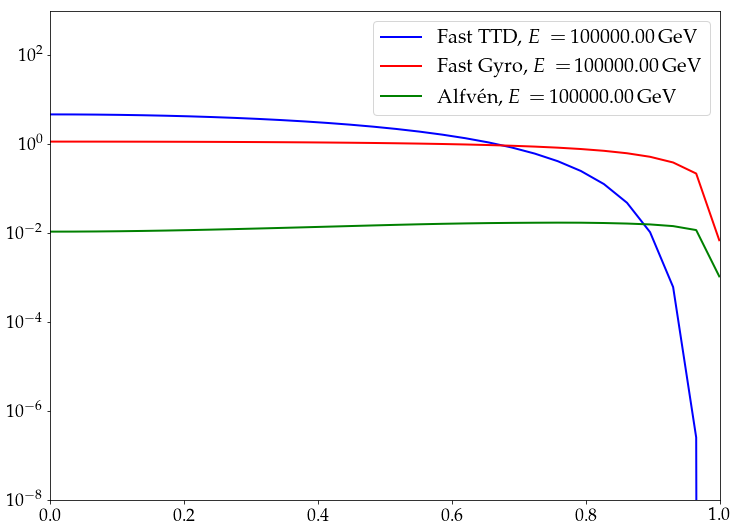

In [9]:
# This block shows the relative contributions of the three modes #

plt.figure(figsize=(12,9))

index_energy = 59     # energy index: check 5, 30, 59 to span the whole range

plt.plot(mu, D_mumu_TTD_over_v_disk[index_energy], lw=2, color='blue', label='Fast TTD, $E \, = \,$'+str( "{:.2f}".format(p_CR[index_energy]) )+'$\, \mathrm{GeV}$')
plt.plot(mu, D_mumu_Gyro_over_v_disk[index_energy], lw=2, color='red', label='Fast Gyro, $E \, = \,$'+str( "{:.2f}".format(p_CR[index_energy]) )+'$\, \mathrm{GeV}$')
plt.plot(mu, D_mumu_Alfven_over_v_disk[index_energy], lw=2, color='green', label='Alfvén, $E \, = \,$'+str( "{:.2f}".format(p_CR[index_energy]) )+'$\, \mathrm{GeV}$')

plt.xlim(0., 1.)
plt.ylim(1.e-8, 1.e+3)
plt.yscale('log')

plt.legend(fontsize=20)

name_saved_pdf_D_mumu = 'D_mumu_disk_Ldisk'+str(L_disk)+'_MA'+str(M_A_disk)+'_xc'+str(x_c)+'_E'+str( "{:.2f}".format(p_CR[index_energy]) )+'.pdf'
plt.savefig( str(name_saved_pdf_D_mumu),format='pdf',bbox_inches='tight', dpi=200 )


I am fitting the curve between 9.714685439081816e-07 and 1.010131455560243e-05
29 39
Fit results: [87.07097287  0.31705201  1.        ]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in power
/usr/local/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


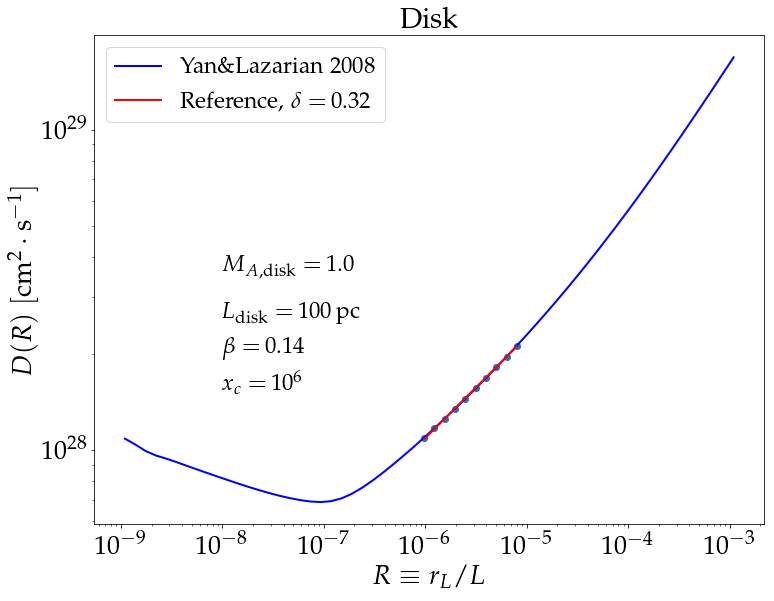

In [13]:
### Plotting block. Also, the slope in the energy-range [100GeV, 1TeV] is computed and drawn ###

plt.figure(figsize=(12,9))

YL08_disk, = plt.plot(R_disk, integral_over_mu_disk, lw=2, color='blue')


## Fitting my curve in the requested range ##
R_disk_np = np.asarray(R_disk)

requested_energy_low = 100.  # in [GeV]
requested_energy_up = 1000.  # in [GeV]
index_requested_energy_low = np.argmin(abs(requested_energy_low - p_CR))
index_requested_energy_up = np.argmin(abs(requested_energy_up - p_CR))

print ("I am fitting the curve between", R_disk[index_requested_energy_low], "and", R_disk[index_requested_energy_up])
print (index_requested_energy_low, index_requested_energy_up)

fitting_index_range = np.arange(index_requested_energy_low, index_requested_energy_up)
fitting_points = integral_over_mu_disk[fitting_index_range]

def fit_func(x, a, b, c):
    return pow(10,28) * a * pow(x, b) + c

popt, pcov = curve_fit(fit_func, R_disk_np[fitting_index_range], fitting_points)

print ("Fit results:", popt)

my_curve_disk, = plt.plot(R_disk_np[fitting_index_range], fit_func(R_disk_np[fitting_index_range], *popt),  color='red', lw=2, ls='-')
plt.scatter(R_disk_np[fitting_index_range], fitting_points, marker='o')
##############################################

# size of the axis ticks
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=26)
ax.tick_params(axis='both', which='minor', labelsize=26)
ax.xaxis.set_tick_params(pad=7)
ax.xaxis.labelpad = 7


plt.title("Disk", fontsize=29, loc='center', pad=None)
plt.xlabel('$R \\equiv r_L/L$',fontsize=27)
plt.ylabel('$D(R) \; [\mathrm{cm}^{2} \cdot \mathrm{s}^{-1}]$',fontsize=27)
plt.xscale('log')
plt.yscale('log')

plt.legend([YL08_disk, my_curve_disk],[
    r'Yan\&Lazarian 2008',
    r'Reference, $\delta = \,$'+ str("{:.2f}".format(popt[1])),
    ],loc='best', fontsize=23)


f = mticker.ScalarFormatter(useMathText=True)
f.set_powerlimits((-5,5))

plt.text(1.e-8, 3.5e+28, r'$M_{A, \mathrm{disk}} = \,$'+str(M_A_disk),fontsize=23)
plt.text(1.e-8, 2.5e+28, r'$L_{\mathrm{disk}} = \,$'+str(L_disk)+'$\, \mathrm{pc}$',fontsize=23)
plt.text(1.e-8, 2.e+28, r'$\beta = \,$'+str(beta_disk),fontsize=23)
plt.text(1.e-8, 1.5e+28, r'$x_c = \,$'+str("${}$".format(f.format_data(x_c))),fontsize=23)


name_saved_pdf = 'D_disk_Ldisk'+str(L_disk)+'_MA'+str(M_A_disk)+'_xc'+str(x_c)+'.pdf'
plt.savefig( str(name_saved_pdf),format='pdf',bbox_inches='tight', dpi=200 )


In [11]:
### Block to store the output D(R) in a text file ###

print (len(p_CR), len(R_disk_np), len(integral_over_mu_disk))

data_for_text_file = np.zeros( (len(p_CR), 3) )

data_for_text_file[:,0] = p_CR
data_for_text_file[:,1] = R_disk_np
data_for_text_file[:,2] = integral_over_mu_disk

#print (data_for_text_file)

txt_file_name = 'D_disk_Ldisk'+str(L_disk)+'_MA'+str(M_A_disk)+'_xc'+str(x_c)+'.txt'
np.savetxt( txt_file_name, data_for_text_file )


60 60 60
